In [2]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

import spacy
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import re

In [3]:
tweetdata = pd.read_csv("../data/testdata.manual.2009.06.14.csv", header=None, encoding="ISO-8859-1")
tweetdata.columns = ['polarity', 'id', 'date', 'source', 'username', 'text']

In [4]:
labels = tweetdata.polarity

In [5]:
# 1/21/19 https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

In [6]:
tweetdata = standardize_text(tweetdata, 'text')
tweet_doc = tweetdata.text.tolist()

In [7]:
import requests
import json

In [8]:
matrix_embedding = np.zeros((len(tweetdata), 300))
for i in range(len(tweetdata)):
    text = tweetdata['text'][i]
    input = {'text' : text}
    response = requests.get('http://0.0.0.0:5000/infer', data=input)
    vector_embedding = json.loads(response.text)
    matrix_embedding[i] = vector_embedding

In [9]:
# define model
model = Sequential()
# e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=31, trainable=False)
# model.add(e)
model.add(Dense(50, input_shape=(300,)))
model.add(Dense(3, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 15,203
Trainable params: 15,203
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
renum_labels = []
for label in labels:
    if label == 0:
        renum_labels.append(0)
    elif label == 2:
        renum_labels.append(1)
    else:
        renum_labels.append(2)

In [11]:
categorical_labels = to_categorical(renum_labels, num_classes=3)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_text, test_text, train_label, test_label = train_test_split(tweetdata.text, 
                                                                  renum_labels, 
                                                                  test_size=0.2, 
                                                                  random_state=40)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(matrix_embedding,
categorical_labels,
test_size=0.2,
random_state=40)

In [15]:
model.fit(X_train, y_train, epochs=5, verbose=0)

In [16]:
y_predicted = model.predict_classes(X_test)

In [17]:
y_predicted

array([0, 2, 1, 2, 1, 2, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0,
       2, 1, 2, 0, 1, 2, 2, 0, 0, 0, 1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2,
       0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 1, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2,
       1, 2, 0, 1, 2, 2, 2, 0, 0, 1, 1, 2, 2, 0, 2, 2, 1, 1, 1, 0, 1, 0,
       0, 1, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0])

In [10]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

In [19]:
cm = confusion_matrix(test_label, y_predicted)

ValueError: Unknown format code 'd' for object of type 'float'

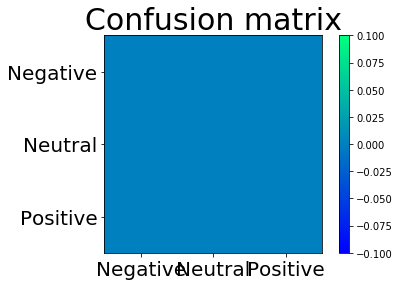

In [12]:
plot_confusion_matrix(np.zeros((3,3)), classes=['Negative','Neutral','Positive'])

In [13]:
y_predicted

NameError: name 'y_predicted' is not defined

In [ ]:
cm = confusion_matrix(test_label, y_predicted)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

In [98]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 77.000000
